In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import datetime
import warnings

In [2]:
# Original data
levels = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]], dtype=np.float32)
salaries = np.array([[45000], [50000], [60000], [80000], [110000], 
                   [150000], [200000], [220000], [250000], [300000]], dtype=np.float32)

# Add interpolated points
new_levels = np.array([[1.5], [2.3], [3.7], [4.5], [5.5], [6.5], [7.5], [8.5], [9.2]])
new_salaries = np.interp(new_levels.flatten(), levels.flatten(), salaries.flatten()).reshape(-1, 1)

levels = np.vstack([levels, new_levels])
salaries = np.vstack([salaries, new_salaries])

In [3]:
class SalaryModel(nn.Module):
    def __init__(self, input_features=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [4]:
# Prepare polynomial features
levels_poly = np.hstack([levels, levels**2, levels**3])

# Initialize and fit scalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(levels_poly)
y_scaled = scaler_y.fit_transform(salaries)

# Convert to tensors
X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

# Split into train and test sets
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

In [5]:
# Initialize model, loss function, and optimizer
model = SalaryModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
EPOCHS = 1000

# Lists to store metrics
train_losses = []
test_losses = []
mae_scores = []
r2_scores = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train)
    train_loss = loss_fn(train_pred, y_train)
    train_loss.backward()
    optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
        
        # Calculate metrics
        y_true = scaler_y.inverse_transform(y_test.numpy()).flatten()
        y_pred = scaler_y.inverse_transform(test_pred.numpy()).flatten()
        
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Store metrics
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        mae_scores.append(mae)
        r2_scores.append(r2)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}")
        print(f"MAE:{mae:,.0f} | R2 Score: {r2:.4f}\n")

Epoch 0 | Train Loss: 1.0836 | Test Loss: 0.7187
MAE:61,757 | R2 Score: -3.8882

Epoch 100 | Train Loss: 0.0007 | Test Loss: 0.0009
MAE:2,130 | R2 Score: 0.9938

Epoch 200 | Train Loss: 0.0003 | Test Loss: 0.0005
MAE:1,652 | R2 Score: 0.9969

Epoch 300 | Train Loss: 0.0001 | Test Loss: 0.0002
MAE:1,067 | R2 Score: 0.9986

Epoch 400 | Train Loss: 0.0000 | Test Loss: 0.0001
MAE:871 | R2 Score: 0.9991

Epoch 500 | Train Loss: 0.0000 | Test Loss: 0.0001
MAE:794 | R2 Score: 0.9991

Epoch 600 | Train Loss: 0.0000 | Test Loss: 0.0001
MAE:859 | R2 Score: 0.9990

Epoch 700 | Train Loss: 0.0000 | Test Loss: 0.0002
MAE:876 | R2 Score: 0.9990

Epoch 800 | Train Loss: 0.0000 | Test Loss: 0.0002
MAE:872 | R2 Score: 0.9990

Epoch 900 | Train Loss: 0.0000 | Test Loss: 0.0002
MAE:868 | R2 Score: 0.9990



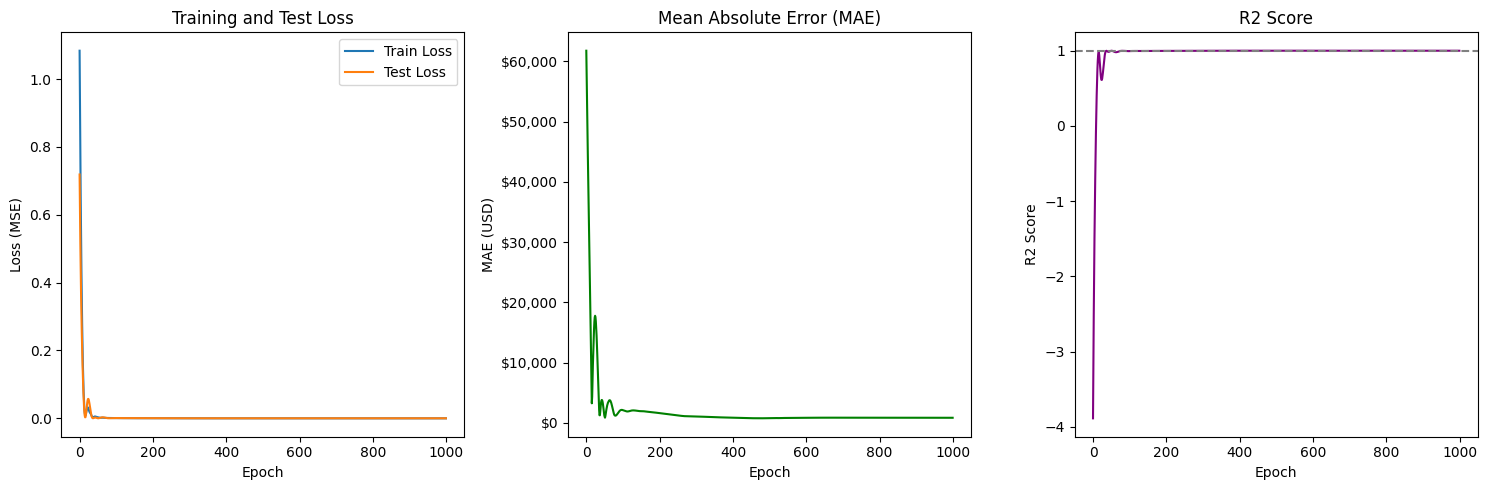

In [6]:
plt.figure(figsize=(15, 5))

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(mae_scores, color='green')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE (USD)')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')

# Plot R2 Score
plt.subplot(1, 3, 3)
plt.plot(r2_scores, color='purple')
plt.title('R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.axhline(y=1.0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

In [7]:
with torch.inference_mode():
    # Get predictions for all data
    all_pred = model(X_tensor)
    y_true_all = scaler_y.inverse_transform(y_tensor.numpy()).flatten()
    y_pred_all = scaler_y.inverse_transform(all_pred.numpy()).flatten()
    level_values = levels.flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mape = mean_absolute_percentage_error(y_true_all, y_pred_all) * 100
    r2 = r2_score(y_true_all, y_pred_all)
    errors = y_true_all - y_pred_all
    percent_errors = (errors / y_true_all) * 100
    
    print("=== Final Model Evaluation ===")
    print(f"Mean Squared Error (MSE): {mse:,.0f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.0f}")
    print(f"Mean Absolute Error (MAE): ${mae:,.0f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R2) Score: {r2:.4f}")
    
    # Create results table
    results = pd.DataFrame({
        'Level': level_values,
        'Actual': y_true_all,
        'Predicted': y_pred_all,
        'Error': errors,
        '% Error': percent_errors
    }).round(2)
    
    print("\n=== Detailed Predictions ===")
    print(results)

=== Final Model Evaluation ===
Mean Squared Error (MSE): 243,219
Root Mean Squared Error (RMSE): $493
Mean Absolute Error (MAE): $291
Mean Absolute Percentage Error (MAPE): 0.24%
R-squared (R2) Score: 1.0000

=== Detailed Predictions ===
    Level    Actual      Predicted        Error  % Error
0     1.0   45000.0   45043.019531   -43.020000    -0.10
1     2.0   50000.0   50329.968750  -329.970001    -0.66
2     3.0   60000.0   60116.039062  -116.050003    -0.19
3     4.0   80000.0   80357.429688  -357.429993    -0.45
4     5.0  110000.0  110135.773438  -135.770004    -0.12
5     6.0  150000.0  150042.921875   -42.919998    -0.03
6     7.0  200000.0  199999.875000     0.120000     0.00
7     8.0  220000.0  219989.062500    10.940000     0.00
8     9.0  250000.0  250012.046875   -12.030000    -0.00
9    10.0  300000.0  299995.031250     4.970000     0.00
10    1.5   47500.0   47343.039062   156.949997     0.33
11    2.3   53000.0   52742.179688   257.820007     0.49
12    3.7   74000.0  

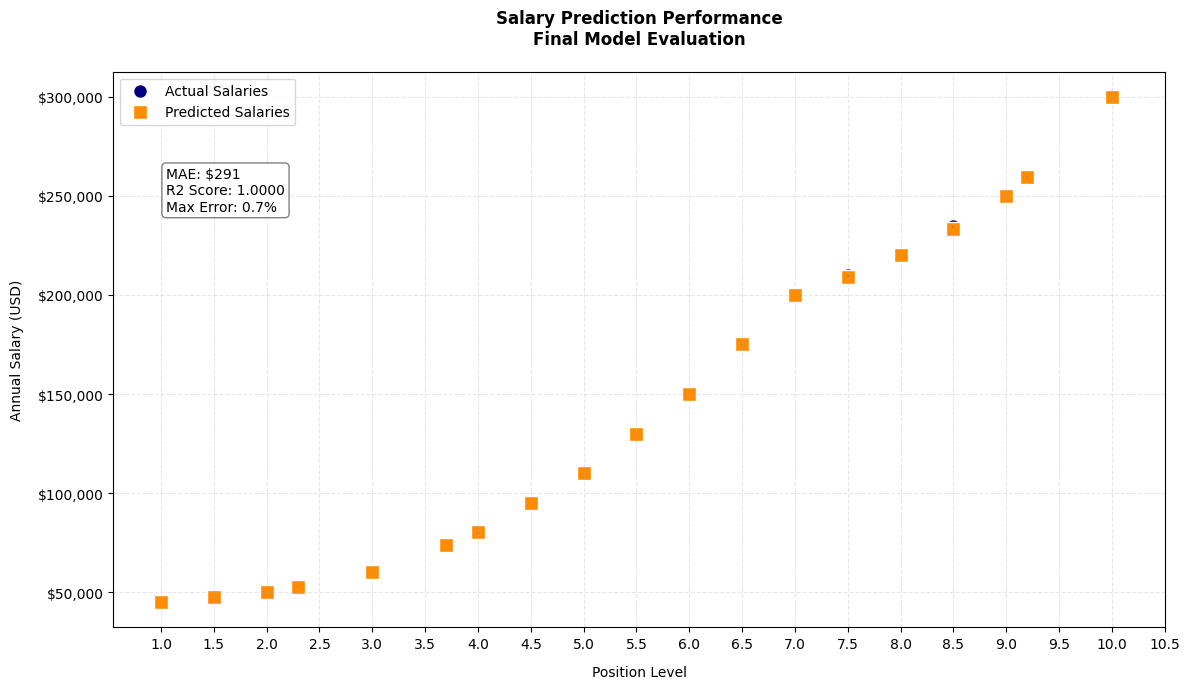

In [8]:
plt.figure(figsize=(12, 7))

# Scatter plot
plt.scatter(level_values, y_true_all, color='navy', s=100, 
           edgecolor='white', label='Actual Salaries')
plt.scatter(level_values, y_pred_all, color='darkorange', s=100, 
           marker='s', edgecolor='white', label='Predicted Salaries')

# Connecting lines
for lvl, actual, pred in zip(level_values, y_true_all, y_pred_all):
    plt.plot([lvl, lvl], [actual, pred], 'gray', linestyle=':', alpha=0.5)

# Formatting
plt.title('Salary Prediction Performance\nFinal Model Evaluation', pad=20, fontweight='bold')
plt.xlabel('Position Level', labelpad=10)
plt.ylabel('Annual Salary (USD)', labelpad=10)
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.xticks(np.arange(min(level_values), max(level_values)+1, 0.5))

# Add metrics box
metrics_text = (f"MAE: ${mae:,.0f}\n"
               f"R2 Score: {r2:.4f}\n"
               f"Max Error: {abs(percent_errors).max():.1f}%")
plt.annotate(metrics_text, xy=(0.05, 0.75), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Create metadata dictionary
metadata = {
    'training_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'input_features': 3,
    'best_epoch': EPOCHS,
    'final_metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'mape': float(mape),
        'r2': float(r2)
    },
    'scaler_info': {
        'x_scaler_mean': scaler_x.mean_.tolist(),
        'x_scaler_scale': scaler_x.scale_.tolist(),
        'y_scaler_mean': scaler_y.mean_.tolist(),
        'y_scaler_scale': scaler_y.scale_.tolist()
    }
}

# Save everything
torch.save({
    'model_state_dict': model.state_dict(),
    'metadata': metadata
}, 'final_salary_model_with_metrics.pth')

# Save scalers
joblib.dump(scaler_x, 'final_scaler_x.pkl')
joblib.dump(scaler_y, 'final_scaler_y.pkl')

print("Model and metrics saved successfully!")
print(f"Model saved as: final_salary_model.pth")
print(f"X scaler saved as: final_scaler_x.pkl")
print(f"Y scaler saved as: final_scaler_y.pkl")

Model and metrics saved successfully!
Model saved as: final_salary_model.pth
X scaler saved as: final_scaler_x.pkl
Y scaler saved as: final_scaler_y.pkl


In [10]:
import os

print("=== File Verification ===")
print(f"Model: {'found' if os.path.exists('final_salary_model.pth') else 'MISSING'} ({os.path.getsize('final_salary_model.pth')/1000:.1f} KB)")
print(f"X Scaler: {'found' if os.path.exists('final_scaler_x.pkl') else 'MISSING'} ({os.path.getsize('final_scaler_x.pkl')/1000:.1f} KB)")
print(f"Y Scaler: {'found' if os.path.exists('final_scaler_y.pkl') else 'MISSING'} ({os.path.getsize('final_scaler_y.pkl')/1000:.1f} KB)")

print("\n=== File Locations ===")
print(f"Current directory: {os.getcwd()}")

=== File Verification ===
Model: found (39.2 KB)
X Scaler: found (0.7 KB)
Y Scaler: found (0.6 KB)

=== File Locations ===
Current directory: C:\Users\Dz-PC\Desktop\Employee_Salary_Project\backend
